In [37]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit_aer import StatevectorSimulator, QasmSimulator, Aer
from qiskit.quantum_info import Statevector
from qiskit.visualization import visualize_transition, plot_histogram, circuit_drawer, plot_bloch_multivector, plot_state_qsphere, array_to_latex
import Our_Qiskit_Functions as oq
from qiskit.circuit.library import QFT
import numpy as np 
from numpy import pi
import math as m
import random
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from qiskit_ibm_runtime import QiskitRuntimeService, Session,Estimator,SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

S_simulator = StatevectorSimulator()
M_simulator = QasmSimulator()

In [38]:
def Binary(N,total,LSB):
  '''
  Input: N (integer) total (integer) LSB (string)
  Returns the base-2 binary equivilant of N according to left or right least significant bit notation
  '''
  qubits = int(m.log(total, 2))
  b_num = np.zeros(qubits)
  for i in np.arange(qubits):
    if( N/((2)**(qubits-i-1)) >= 1):
      if (LSB == 'R'):
        b_num[i] = 1
      if(LSB== 'L'):
        b_num[int(qubits-(i+1))] = 1
      N = N - 2**(qubits-i-1)
  B = []
  for j in np.arange(len(b_num)): 
    B.append(int(b_num[j]))
  return B

In [39]:
def From_Binary(S, LSB):
    '''
    Input:
    S (string or array)
    LSB (string)
    Converts a base-2 binary number to base-10 according to left or right least significant bit notation
    '''
    num = 0
    for i in np.arange(len(S)):
    	if(LSB=='R'):
    		num = num + int(S[int(0-(i+1))]) * 2**(i)
    	if(LSB=='L'):
    		num = num + int(S[int(i)]) * 2**(i)
    return num

In [40]:
def Wavefunction( obj, *args, **kwargs):
  '''
  Displays the wavefunction of the quantum system
  '''
  if(type(obj) == QuantumCircuit ):
    statevec = S_simulator.run(obj, shots=1 ).result().get_statevector() 
  if(type(obj) == np.ndarray):
    statevec = obj
  sys = False
  NL = False
  dec = 5
  if 'precision' in kwargs:
    dec = int(kwargs['precision'] )  
  if 'column' in kwargs:  
    NL = kwargs['column']
  if 'systems' in kwargs:
    systems=kwargs['systems']
    sys = True
    last_sys= int(len(systems)-1)
    show_systems = []
    for s_chk in np.arange(len(systems)): 
      if( type(systems [s_chk])!=int ):
        raise Exception('systems must be an array of all integers')
    if 'show_systems' in kwargs: 
      show_systems = kwargs['show_systems']
      if(len(systems)!=len (show_systems) ):
        raise Exception('systems and show_systems need to be arrays of equal length')
      for ls in np.arange(len(show_systems)): 
        if((show_systems [ ls]!=True) and (show_systems [ ls] !=False)): 
          raise Exception('show_systems must be an array of Truth Values') 
        if(show_systems [ ls] ==True): 
          last_sys= int(ls)

    else:
      for ss in np.arange(len(systems)): 
        show_systems.append(True)
  wavefunction = ''
  qubits = int(m.log(len(np.asarray(statevec)),2)) 
  for i in np.arange( int(len(np.asarray(statevec))) ): 
    value = round(statevec[int(i)].real, dec) + round(statevec[int(i)].imag, dec) * 1j
    if( (value.real!=0) or (value.imag!=0)): 
      state= list(Binary(int(i), int(2**qubits),'L'))
      state_str = ''
      if( sys == True ):    #Systems and Show Systems
        k = 0 
        for s in np.arange(len(systems)):
          if(show_systems [s]==True):
            if(int(s)!=last_sys):
              state.insert(int(k+systems [s]), '>|' ) 
              k = int(k+systems[s]+1)
            else:
              k = int(k+systems[s])
          else:
            for s2 in np.arange(systems [s]): 
              del state[int(k)]
      for j in np.arange(len(state)):
        if(type(state[j])!=str):
          state_str = state_str+str(int(state[j]))
        else:
          state_str = state_str+state[j]
      if ((value.real!=0) and (value.imag!=0)):
        if( value.imag> 0):
          wavefunction = wavefunction + str(value.real) + '+' + str(value.imag) + 'j |' + state_str + '>   '
        else:
          wavefunction = wavefunction + str(value.real) +'' + str(value.imag) + 'j |' + state_str + '>    '
      if( (value.real!=0) and (value.imag==0)): 
        wavefunction = wavefunction +str(value.real)+' |'+state_str +'>     '
      if((value.real==0) and (value.imag!=0)): 
        wavefunction = wavefunction +str(value.imag)+'j |'+state_str+ '>     '
      if (NL):
        wavefunction = wavefunction + '\n'
  print(wavefunction)

In [41]:
def Measurement(quantumcircuit, **kwargs):
  '''
  Executes a measurement(s) of a QuantumCircuit object for tidier printing
  Keyword Arguments:
  shots (integer) - number of trials to execute for the measurement(s)
  return_M (Bool) - indictaes whether to return the Dictionary object containng measurement resul
  print_M (Bool) - indictaes whether to print the measurement results
  column (Bool) - prints each state in a vertical column
  '''
  p_M = True
  S=1
  ret = False
  NL = False
  if 'shots' in kwargs:
    S = int(kwargs['shots'])
  if 'return_M' in kwargs:
    ret = kwargs['return_M']
  if 'print_M' in kwargs:
    p_M = kwargs['print_M']
  if 'column' in kwargs:
    NL = kwargs['column']
  M1 = M_simulator.run(quantumcircuit, shots=S).result().get_counts(quantumcircuit)
  M2 = {}
  k1 = list(M1.keys())
  v1 = list(M1.values())
  for k in np.arange(len(k1)):
    key_list = list(k1[k])
    new_key = ''
    for j in np.arange(len(key_list)):
      new_key = new_key+key_list[len(key_list)-(j+1)]
    M2[new_key] = v1[k]
  if(p_M):
    k2 = list(M2.keys())
    v2 = list(M2.values())
    measurements = ''
    for i in np.arange( len(k2) ):
      m_str = str(v2[i])+'|'
      for j in np.arange(len(k2[i])):
        if( k2[i][j] == '0' ):
          m_str = m_str+'0'
        if( k2[i][j] == '1' ):
          m_str = m_str+'1'
        if( k2[i][j] == ' ' ):
          m_str = m_str+'>|'
      m_str = m_str+'>   '
      if(NL):
        m_str = m_str + '\n'
      measurements = measurements + m_str
    print(measurements)
  if(ret):
    return M2

In [42]:
def QFT_dgr (qc, q, qubits, **kwargs):
  '''
  Input: qc (QuantumCircuit), q (QuantumRegister), qubits (integer)
  Keyword Arguments: swap (Bool) - Adds SWAP gates after all of the phase gates have been applied 
  Assigns all the gate operations for a Quantum Fourier Transformation
  '''
  if 'swap' in kwargs:
    if(kwargs['swap'] == True):
      for s in np.arange(m.floor(qubits/2.0)):
        qc.swap( q[int(s)],q[int(qubits-1-s)] )
  
  R_phis = [0]

  for i in np.arange(2,int(qubits+1)):
    R_phis.append(-2/(2**(i))*m.pi )
  
  for j in np.arange(int(qubits)): 
    for k in np.arange( int(j) ):
      qc.cp(R_phis[int(qubits - (k+1))], q[int(qubits - (k+1))], q[int(qubits - (j+1))] )
    qc.h( q[int(qubits - (j+1))] )

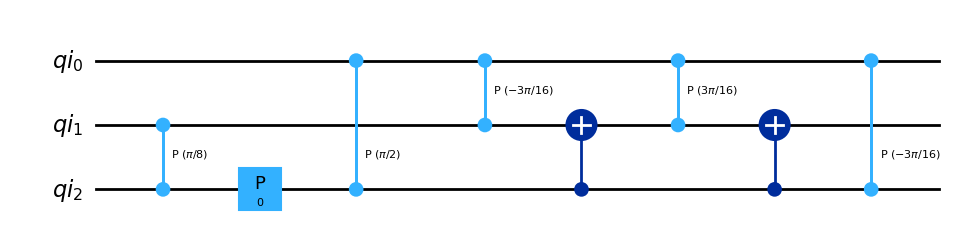

In [43]:
# Intial Circuit 

q = QuantumRegister(3, name ='q')
qci = QuantumCircuit(q, name='qc')

ai = 0
bi = np.pi/2
ci = np.pi/8
di = np.pi/4

qi = QuantumRegister(3, 'qi')
qci = QuantumCircuit(qi)


qci.cp(ci - ai, qi[2], qi[1])
qci.p(ai, qi[2])
qci.cp(bi - ai, qi[2], qi[0])

qci.cp((di - ci + ai - bi)/2, qi[1], qi[0])
qci.cx(qi[2], qi[1])
qci.cp(-(di - ci + ai - bi)/2, qi[1], qi[0])
qci.cx(qi[2], qi[1])
qci.cp((di - ci + ai - bi)/2, qi[2], qi[0])

#qci.qci
qci.draw('mpl')


In [44]:
backend = Aer.get_backend('unitary_simulator')
qci_transpiled = transpile(qci,backend)
job=backend.run(qci_transpiled)
result = job.result()
unitary_matrix_1 = result.get_unitary()
array_to_latex(unitary_matrix_1, prefix="\\text{Circuit = }\n")

<IPython.core.display.Latex object>

In [45]:
def controlled_unitary(qc, qubits: list, phases: list): # x,y,z = Specific Qubit; a,b,c,d = Phases
    qc.cp(phases[2]-phases[0], qubits[0], qubits[1]) # controlled-U1(c-a)
    qc.p(phases[0], qubits[0]) # U1(a)
    qc.cp(phases[1]-phases[0], qubits[0], qubits[2]) # controlled-U1(b-a)
    
    # controlled controlled U1(d-c+a-b)
    qc.cp((phases[3]-phases[2]+phases[0]-phases[1])/2, qubits[1], qubits[2])
    qc.cx(qubits[0], qubits[1])
    qc.cp(-(phases[3]-phases[2]+phases[0]-phases[1])/2, qubits[1], qubits[2])
    qc.cx(qubits[0], qubits[1])
    qc.cp((phases[3]-phases[2]+phases[0]-phases[1])/2, qubits[0], qubits[2])

In [46]:
def U(times, qc, unit, eigen, phases: list): # a,b,c = phases for U1; d,e,f = phases for U2; g,h,i = phases for U3; j,k,l = phases for U4; m_list=[m, n, o, p, q, r, s, t, u, a, b, c, d, e, f, g, h, i, j, k, l]
    controlled_unitary(qc, [unit[0]]+eigen[0:2], [0]+phases[0:3])
    controlled_unitary(qc, [unit[0]]+eigen[2:4], [phases[3]]+[0]+phases[4:6])
    controlled_unitary(qc, [unit[0]]+eigen[4:6], phases[6:8]+[0]+[phases[8]])
    controlled_unitary(qc, [unit[0]]+eigen[6:8], phases[9:12]+[0])


In [47]:
def final_U1(times, eigen, phases: list):
    unit = QuantumRegister(1, 'unit')
    qc = QuantumCircuit(unit, eigen)
    for _ in range(2**times):
        U(times, qc, unit, eigen, phases)
    return qc.to_gate(label='U'+'_'+(str(2**times)))



In [48]:
# Storing the eigenvalues in a list
eigen_values = ["11000110", "10001101", "11001001"]

# Function to place appropriate corresponding gate according to eigenstates
def eigenstates(qc, eigen, index):
    for i in range(0, len(eigen)):
        if eigen_values[index][i] == '1':
            qc.x(eigen[i])
        if eigen_values[index][i] == '0':
            pass
    qc.barrier()
    return qc

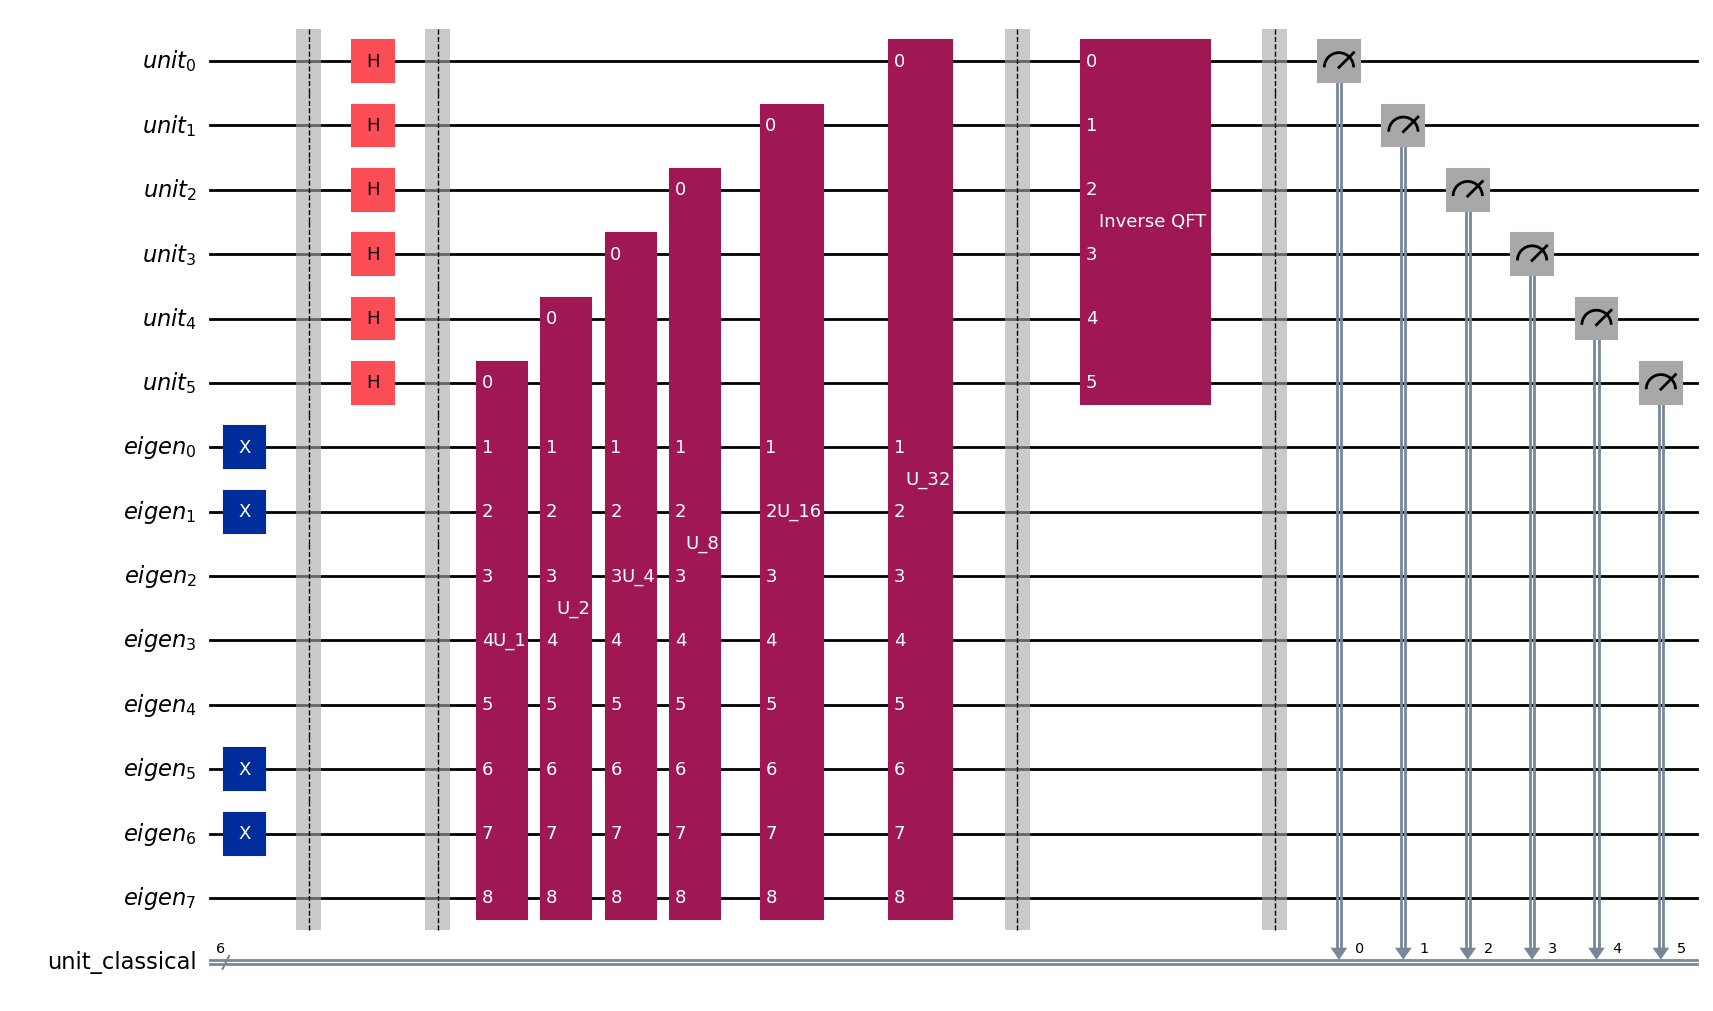

In [55]:
# Initialization
unit = QuantumRegister(6, 'unit')
eigen = QuantumRegister(8, 'eigen')
unit_classical = ClassicalRegister(6, 'unit_classical')
qc= QuantumCircuit(unit, eigen, unit_classical)
eigenstates(qc, eigen, 0)
#

# Hadamard on the 'unit' qubits
qc.h(unit[:])
qc.barrier()

phases = [pi / 2, pi / 8, pi / 4, pi / 2, pi / 4, pi / 4, pi / 8, pi / 4, pi / 8, pi / 4, pi / 4, pi / 8] # a, b, c, d, e, f, g, h, i, j, k, l
for i in range(0, 6):
    qc.append(final_U1(i, eigen, phases), [unit[5-i]] + eigen[:])
# Inverse QFT 
qc.barrier()
qft = QFT(num_qubits=len(unit), inverse=True, insert_barriers=True, do_swaps=False, name='Inverse QFT')
qc.append(qft, qc.qubits[:len(unit)])
qc.barrier()
#

# Measure
qc.measure(unit, unit_classical)
#

# Draw
qc.draw('mpl')

Result(backend_name='qasm_simulator', backend_version='0.14.2', qobj_id='', job_id='4f5799ed-4431-46c9-9091-4dbbe47cb622', success=True, results=[ExperimentResult(shots=1024, success=True, meas_level=2, data=ExperimentResultData(counts={'0x24': 1024}), header=QobjExperimentHeader(creg_sizes=[['unit_classical', 6]], global_phase=0.0, memory_slots=6, n_qubits=14, name='circuit-303', qreg_sizes=[['unit', 6], ['eigen', 8]], metadata={}), status=DONE, seed_simulator=3597595156, metadata={'batched_shots_optimization': False, 'required_memory_mb': 1, 'method': 'statevector', 'active_input_qubits': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], 'device': 'CPU', 'remapped_qubits': False, 'num_qubits': 14, 'num_clbits': 6, 'time_taken': 0.0934376, 'sample_measure_time': 0.0011151, 'input_qubit_map': [[0, 0], [1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10], [11, 11], [12, 12], [13, 13]], 'max_memory_mb': 8067, 'measure_sampling': True, 'noise': 'ideal', 'parallel

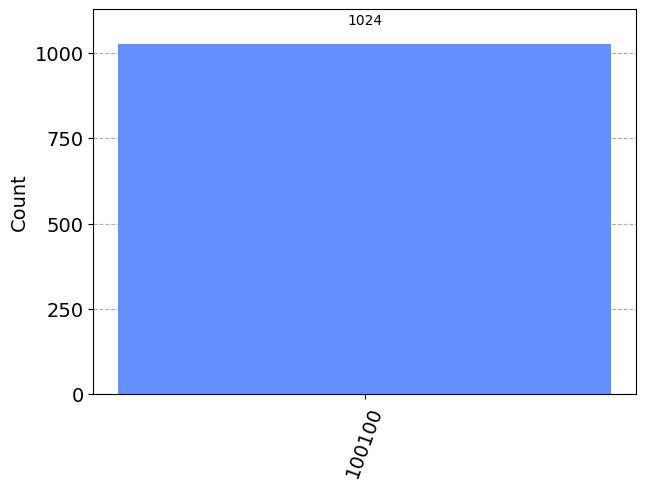

In [ ]:
# backend = Aer.get_backend('qasm_simulator')
# transpileQc= transpile(qc, backend)
# job = backend.run(transpileQc)
# result = job.result()
# print(result)
# count= result.get_counts()
# print(count)
# plot_histogram(count)

In [56]:
provider = QiskitRuntimeService(channel="ibm_quantum", token="94026194e8779a875fd52a9dd514fff408de064c058d43ba63e6c93d8902b6ff39bc7a34ae4862a0eb22b66fb8f48960652b92bc03081269e833e01b7fccd352")
provider = provider.get_backend("ibm_brisbane")
backend = provider
print("least busy backend: ", backend)

least busy backend:  <IBMBackend('ibm_brisbane')>


In [57]:
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
pm_circuit = pm.run(qc)
sampler = Sampler(backend)
job = sampler.run([(pm_circuit)])
print(f"job id: {job.job_id()}")
result = job.result()
print(result)

job id: d02ccz3d8drg008jjy60
PrimitiveResult([{'__type__': 'SamplerPubResult', '__value__': {'data': DataBin<>(unit_classical=BitArray(<shape=(), num_shots=4096, num_bits=6>)), 'metadata': {'circuit_metadata': {}}}}], metadata={'execution': {'execution_spans': {'__type__': 'ExecutionSpanCollection', '__value__': {'spans': [{'__type__': 'DoubleSliceSpan', '__value__': {'start': datetime.datetime(2025, 4, 20, 10, 3, 46, 680765), 'stop': datetime.datetime(2025, 4, 20, 10, 4, 5, 940679), 'data_slices': {'0': [[4096], 0, 1, 0, 4096]}}}]}}}, 'version': 2})


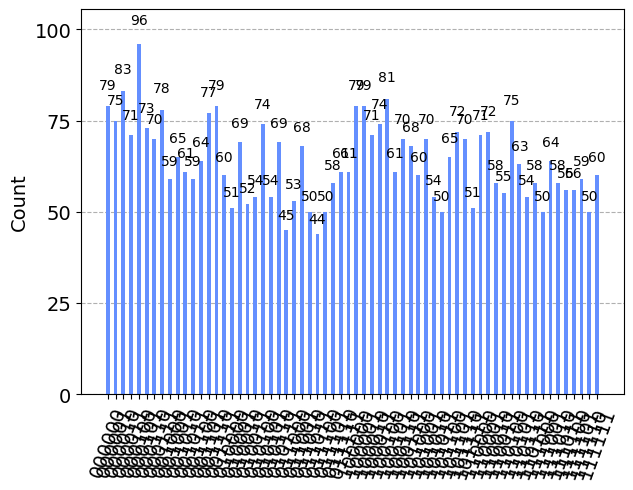

In [59]:
answer = result[0]['__value__']['data'].unit_classical.get_counts()

plot_histogram(answer)

In [67]:
print(answer)

{'110110': 54, '110011': 55, '110111': 58, '100010': 71, '001111': 60, '011010': 50, '000110': 70, '110000': 71, '101111': 51, '101000': 60, '010010': 52, '000111': 78, '100001': 79, '100000': 79, '000011': 71, '101101': 72, '000001': 75, '111111': 60, '001101': 77, '010100': 74, '111101': 59, '001110': 79, '111110': 50, '111001': 64, '100100': 81, '000000': 79, '100101': 61, '010001': 69, '000010': 83, '011011': 44, '010011': 54, '101001': 70, '010000': 51, '100110': 70, '111011': 56, '010111': 45, '011111': 61, '110101': 63, '000100': 96, '010110': 69, '110010': 58, '011001': 68, '101100': 65, '101110': 70, '101010': 54, '011110': 61, '100011': 74, '101011': 50, '001001': 65, '000101': 73, '111100': 56, '110001': 72, '011100': 50, '001011': 59, '011101': 58, '001000': 59, '111000': 50, '100111': 68, '111010': 58, '001010': 61, '001100': 64, '010101': 54, '110100': 75, '011000': 53}


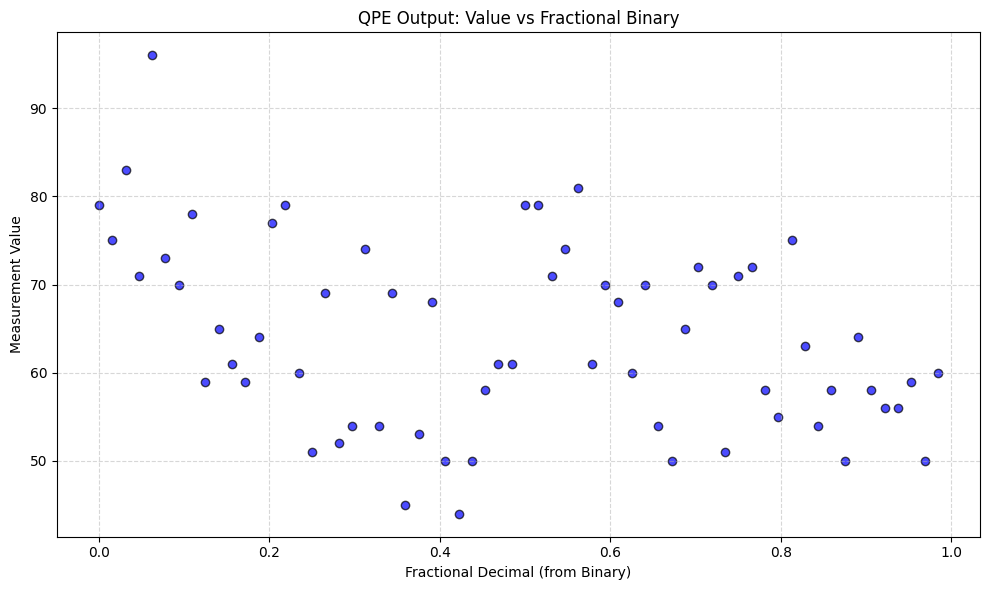

In [74]:
def binary_fraction_to_decimal(binary_str):
    # Initialize the decimal value
    decimal_value = 0.0

    # Loop through the binary string
    for i, bit in enumerate(binary_str):
        if bit == '1':
            # Add the fractional value corresponding to the bit position
            decimal_value += 1 / (2 ** (i + 1))
    
    return decimal_value

# Convert to x (fractional values) and y (original values)
x_vals = [binary_fraction_to_decimal(k) for k in answer]
y_vals = list(answer.values())

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(x_vals, y_vals, color='blue', edgecolor='black', alpha=0.7)
plt.xlabel("Fractional Decimal (from Binary)")
plt.ylabel("Measurement Value")
plt.title("QPE Output: Value vs Fractional Binary")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()